## David Lohmann

<h1 align="center">India Crop Prices Analysis</h1>


This notebook is dedicated to finding out information about Google search terms relating to "crop prices" searched in India. The goal is to provide insights into th thoughts of farmers in this country. The main purpose was to learn to use some Python regression and data analysis tools and techniques.


In [2]:
import pandas as pd
import os

# Access Google drive
from google.colab import auth, drive
from google.auth import default
from oauth2client.client import GoogleCredentials

# Access Google spreadsheet
import gspread

# Fourier analysis
import scipy.fftpack

# Other plotting
import matplotlib.pyplot as plt

# Other math
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# Access Google Drive for data
# Mount from Google drive
# drive.mount('/content/gdrive')

auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)
# gc = gspread.authorize(GoogleCredentials.get_application_default())




In [ ]:
# Read in the data
# This is a Google trends csv file indicating the popularity of the search term "wheat prices" in India for every month from June 2004 to July 2019, relative to the month of max popularity with level 100
worksheet = gc.open('multiTimeline.csv').sheet1
rows = worksheet.get_all_values()
df = pd.DataFrame.from_records(rows)
#df = pd.read_csv('gdrive/My Drive/multiTimeline.csv.gsheet')

In [ ]:
# Read from Google sheet to pandas dataframe
df_search = pd.DataFrame.from_records(rows)

# Rename column's to 3rd line in file
df.rename(columns=df.iloc[2], inplace=True)

# Drop 1st - 3rd lines in file to get the data
df.drop(df.index[0:3], inplace=True)

# Reset the indexes to start at 0, since first few rows were dropped
df.reset_index(drop=True, inplace=True)

# Convert data types to datetime for the months, and ints for the crop price search term value
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m-%d')
df['wheat prices: (India)'] = pd.to_numeric(df['wheat prices: (India)'], downcast='integer')

# Set the index to the month
df.set_index('Month', inplace=True)
#df.index = pd.to_datetime(df.index)

print(df)

            wheat prices: (India)
Month                            
2004-01-01                      0
2004-02-01                     77
2004-03-01                     99
2004-04-01                     74
2004-05-01                     63
...                           ...
2019-03-01                      1
2019-04-01                      2
2019-05-01                      2
2019-06-01                      1
2019-07-01                      7

[187 rows x 1 columns]


In [ ]:
#df.dtypes
#os.listdir('gdrive/My Drive')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 187 entries, 2004-01-01 to 2019-07-01
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   wheat prices: (India)  187 non-null    int8 
dtypes: int8(1)
memory usage: 1.6 KB


<Axes: title={'center': "Frequency of the search term 'wheat prices' on Google in India"}, xlabel='Month'>

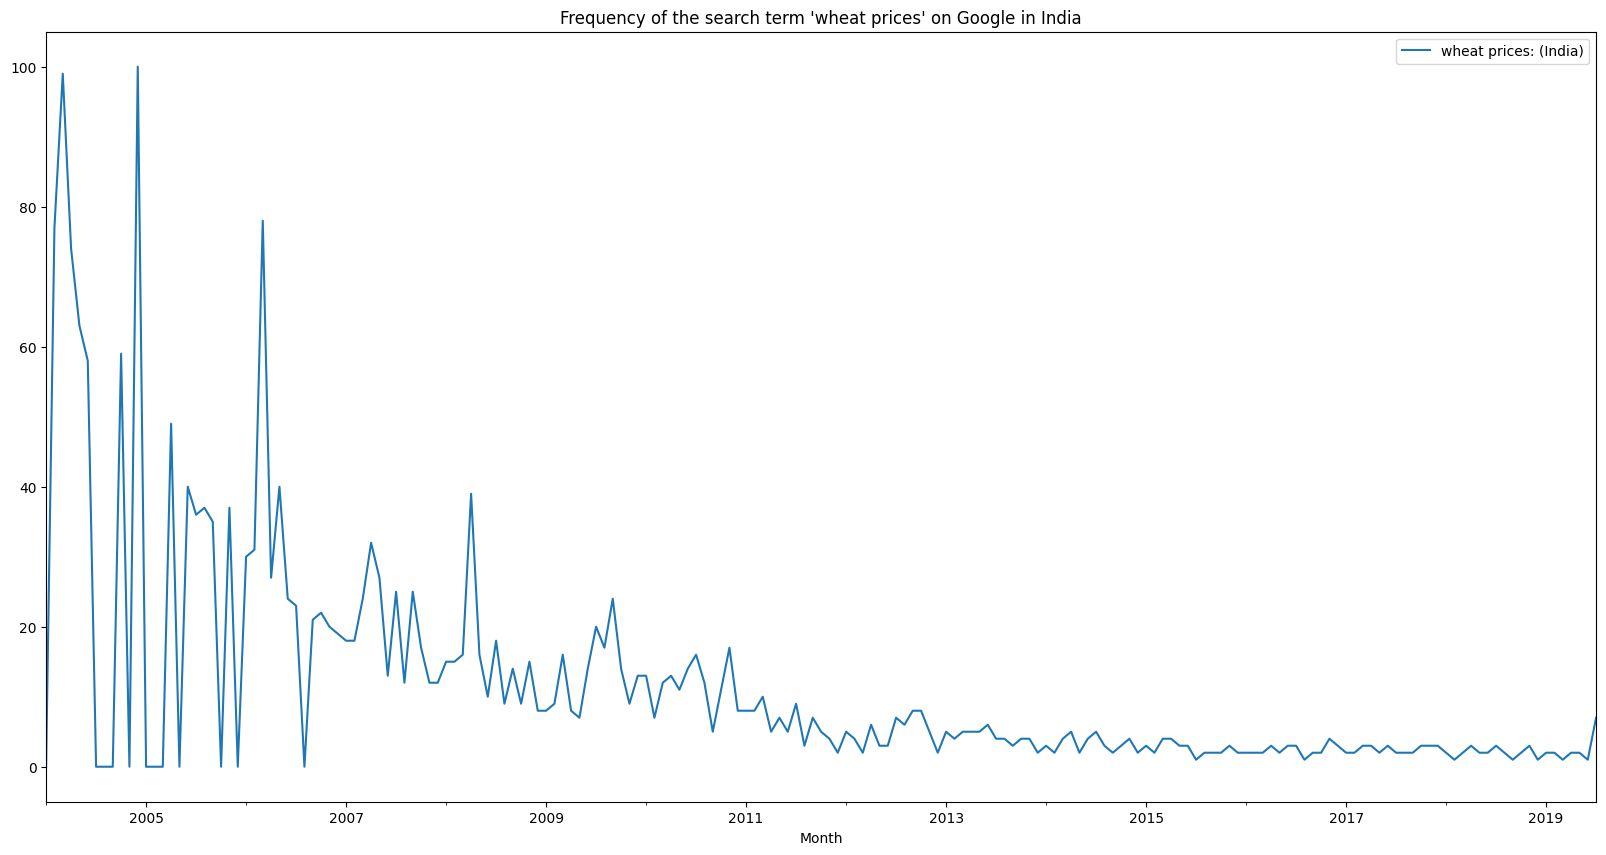

In [ ]:
# Make a line plot
df.plot(kind='line', title='Frequency of the search term \'wheat prices\' on Google in India', figsize=(20, 10))

I suspect that the reason why the Google trends for the search query "wheat prices" in India swung so wildly from 2004 - 2007 could possibly have been because Google Search may have been newer and less popular in India back then, and so a **relatively small change** in the absolute number of queries could have had a **large impact on the overall relative popularity** of that search term. Later on, as more users in India began using Google, the relative proportion of the query "wheat prices" may have undergone regression to the mean as a result of the [law of large numbers](https://en.wikipedia.org/wiki/Law_of_large_numbers).


To [quote from Google trends](https://newsinitiative.withgoogle.com/resources/trainings/fundamentals/google-trends-understanding-the-data/#:~:text=Reading%20the%20Interest%20Over%20Time%20graph.), the Google trends value is from 0 to 100 representing "*how many searches have been done for the particular term relative to the total number of searches done on Google*"

"*Numbers on the graph don't represent absolute search volume numbers, because the **data is normalised and presented on a scale from 0-100**, where each point on the graph is **divided by the highest point, or 100**. The numbers next to the search terms at the top of the graph are sums, or totals.
A line trending downward means that a search term's relative popularity is decreasing—not necessarily that the total number of searches for that term is decreasing, but that its popularity compared to other searches is shrinking.*"

So if I understand correctly, if a Python list `monthly_absolute_term_quereies` represented the total monthly queries for "wheat prices" in India and a Python list `monthly_total_google_queries` represented the number of all Google queries that month for all search terms in India, the trend would be something like:
```python
relative_fraction = [monthly_absolute_term_quereies[i] / monthly_total_google_queries[i] for i in range(len(monthly_total_google_queries))]
google_trend_score = [100 *(proportion / max(relative_fraction)) for proportion in relative_fraction]
```


In [ ]:
# Fourier analysis
yf = scipy.fftpack.fft(df)
xf = np.linspace(0.0, 1.0, len(yf))

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


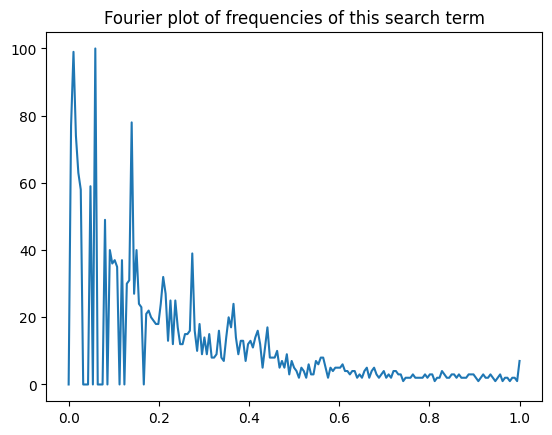

In [ ]:
fig, ax = plt.subplots()
ax.plot(xf, yf)
ax.set_title('Fourier plot of frequencies of this search term')
plt.show()

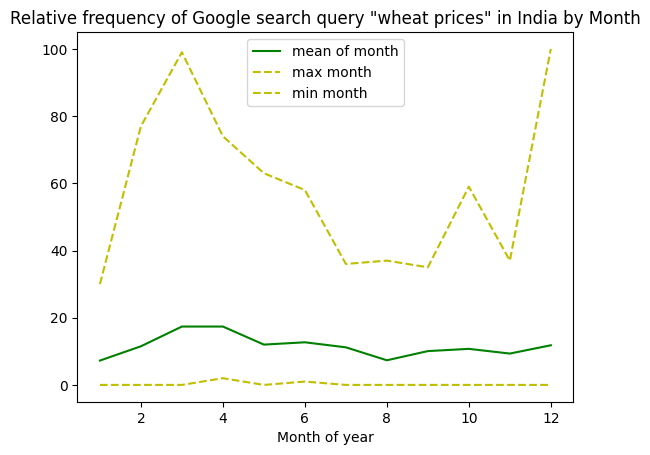

In [ ]:
# Make histogram of most common months for this search term

by_month = df.groupby(by=df.index.month)
plt.plot(by_month.mean(), 'g', label='mean of month')
plt.plot(by_month.max(), 'y', linestyle='dashed', label='max month')
plt.plot(by_month.min(), 'y', linestyle='dashed', label='min month')
plt.xlabel('Month of year')
plt.legend()
plt.title('Relative frequency of Google search query "wheat prices" in India by Month')
plt.show()

The query "wheat prices" appears most popular in India around March or April.

The query I previously used when I wrote this notebook in 2019 was:
```sql
SELECT year, value
FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population`
WHERE country_name ="India" AND indicator_name="Population, total"
ORDER BY year ASC
```

While the query worked in 2019, it seems that Google BigQuery has some error where all populations for all countries and all years are set to 1.0 as the value (except for relative % population). The World Bank website appears to show the same data, except correct. But BigQuery seems to have messed up the data sometime between 2019 when I previously ran this query and now in 2023.


###  Old query, now broken by bugquery update as of October 2023:

In [ ]:
# Set the id for using Google cloud api for BigQuery
# project_id = 'learnprojectindiacropprices'

# Population of India over time
# Read from Bigquery public dataset
# df_population = pd.io.gbq.read_gbq('''
#   SELECT year, value
#   FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population`
#   WHERE country_name ="India" AND indicator_name="Population, total"
#   ORDER BY year ASC
# ''', project_id=project_id, dialect='standard')






# Other Exploratory Data Analysus queries to explore this data table:
# SELECT DISTINCT country_name
# FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population`
# ORDER BY country_name

# SELECT DISTINCT indicator_code
# FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population`

# SELECT DISTINCT indicator_name
# FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population`

# Web use: https://cloud.google.com/bigquery/docs/quickstarts/quickstart-web-ui

### New, working query as of October 2023:

In [25]:
# Set the id for using Google cloud api for BigQuery
project_id = 'learnprojectindiacropprices'

# Population of India over time
# Read from Bigquery public dataset
df_population_bigquery = pd.io.gbq.read_gbq('''
  SELECT *
  FROM `bigquery-public-data.world_bank_global_population.population_by_country`
  WHERE country = "India"
  ORDER BY country ASC
  LIMIT 1000
''', project_id=project_id, dialect='standard')




In [88]:
df_population = df_population_bigquery.drop(columns=['country', 'country_code']).T
df_population.index = pd.to_datetime(df_population.index, format='year_%Y')
df_population.rename(columns={0: 'population'}, inplace=True)
df_population.index.rename('year', inplace=True)
df_population.dropna(inplace=True)
df_population.head()

population
year                  
1960-01-01   450547679
1961-01-01   459642165
1962-01-01   469077190
1963-01-01   478825608
1964-01-01   488848135

In [89]:
df_population.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59 entries, 1960-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   population  59 non-null     Int64
dtypes: Int64(1)
memory usage: 1003.0 bytes


Data for 59 years, from 1960-01-01 00:00:00 to 2018-01-01 00:00:00


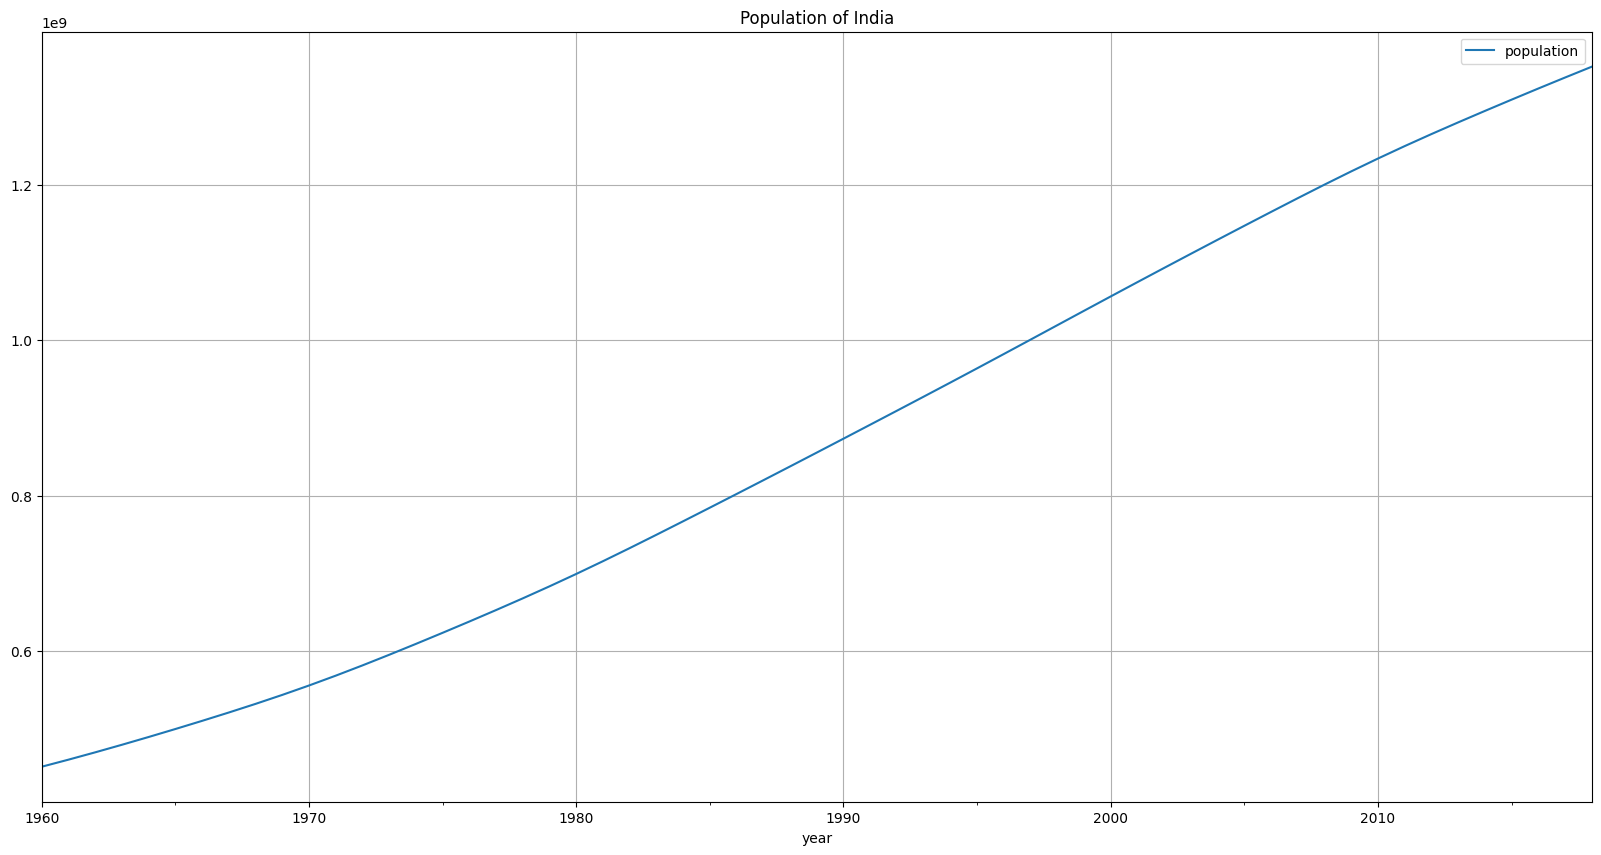

In [90]:
df_population.plot(kind='line', title='Population of India', figsize=(20, 10), grid=True)
print("Data for " + str(len(df_population)) + " years, from " + str(df_population.index[0]) + " to " + str(df_population.index[- 1]))

In [95]:
# Fit a line to the data

# Split into training and testing sections
# We will use years 1960-1999 as the training set, and years 2000 and after as the testing set
train_data = df_population.iloc[:df_population.index.get_loc(datetime(year = 2000, month = 1, day = 1))]  # Population data before 2000
test_data =  df_population.iloc[ df_population.index.get_loc(datetime(year = 2000, month = 1, day = 1)):] # Population data after 2000

# The linear model can only handle numbers but not datetime
train_data.index = train_data.index.year
test_data.index = test_data.index.year

# Split into x and y (input and output) variables
#train_x = train_data['year']
#train_x = np.array(train_data.index)
#train_y = np.array(train_data['value'])

# Train data
#train_x = train_data.index
#train_y = train_data['value']
train_x = np.array(train_data.index)
train_y = np.array(train_data['population'], dtype=np.int64)

train_x = train_x.reshape(-1, 1)
train_y = train_y.reshape(-1, 1)

# Test data
#test_x = test_data.index
#test_y = test_data['value']
test_x = np.array(test_data.index)
test_y = np.array(test_data['population'], dtype=np.int64)

test_x = test_x.reshape(-1, 1)
test_y = test_y.reshape(-1, 1)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(train_x, train_y)

# Make predictions using the testing set
pred_y = regr.predict(test_x)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(test_y, pred_y))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(test_y, pred_y))



Coefficients: 
 [[15372279.43001877]]
Mean squared error: 2355098467946090.50
Variance score: 0.71


In [99]:
regr.intercept_

array([-2.97185446e+10])

In [102]:
print("Double checking the linear regression model:")
print("prediction for " + str(test_x[10][0]) + " is " + str(pred_y[10][0]) + " which is around " + str(regr.coef_[0][0]) + " * (" + str(test_x[10][0]) + ") + " + str(regr.intercept_[0]) + " = " + str(regr.coef_[0][0]*test_x[10][0] +regr.intercept_[0]))

Double checking the linear regression model:
prediction for 2010 is 1179737098.61557 which is around 15372279.430018766 * (2010) + -29718544555.72215 = 1179737098.61557


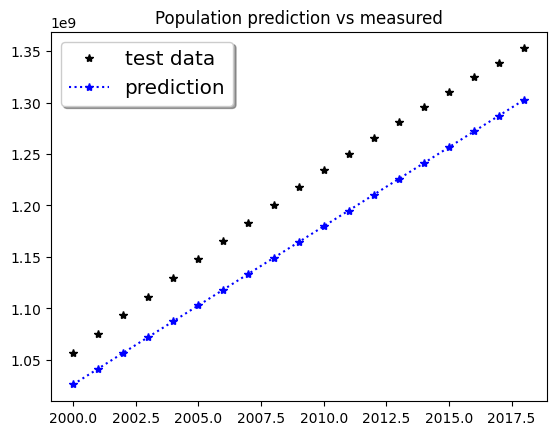

In [103]:
# Plot outputs
#plt.scatter(test_x, test_y,  color='black')
#plt.plot(test_x, pred_y, color='blue', linewidth=3)
#plt.title('Population prediction vs measured')

fig, ax = plt.subplots()
ax.plot(test_x, test_y, 'k*', label='test data')
ax.plot(test_x, pred_y, 'b*:', label='prediction')
plt.title('Population prediction vs measured')

legend = ax.legend(shadow=True, fontsize='x-large')

plt.show()

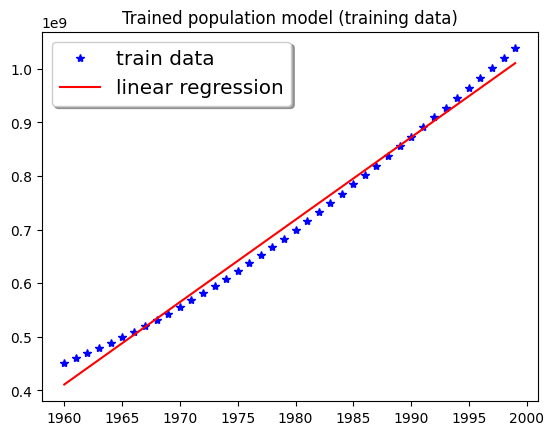

In [107]:
# Plot the data that the model trained on
fig, ax = plt.subplots()
ax.plot(train_x, train_y, 'b*', label='train data')
ax.plot(train_x, regr.predict(train_x), 'r-', label='linear regression')
plt.title('Trained population model (training data)')

legend = ax.legend(shadow=True, fontsize='x-large')

plt.show()

The population growth does not appear perfectly linear, but rather concave up. This indicates accelerating growth in these years. Nevertheless the linear model is an acceptable approximation.

## Unrelated: Learning Fourier transform:

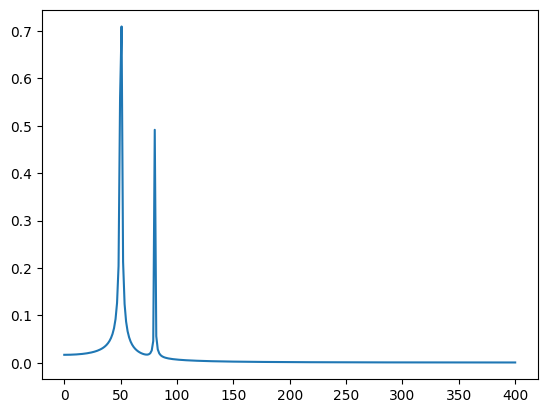

In [109]:
N = 600
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.show()

The coefficients in the sine function, `w1 = 50.0 * 2.0*np.pi = 100 * pi` and `w2 = 80.0 * 2.0*np.pi = 160 * pi` indicate that the periods of these sine functions, using the formula `T = 2*pi / w`, would be `T1 = 1/50` and `T2 = 1 / 80` respectively. The frequency, using the formula `f = 1 / T` would be `f1 = 50` and `f2 = 80` respectively.





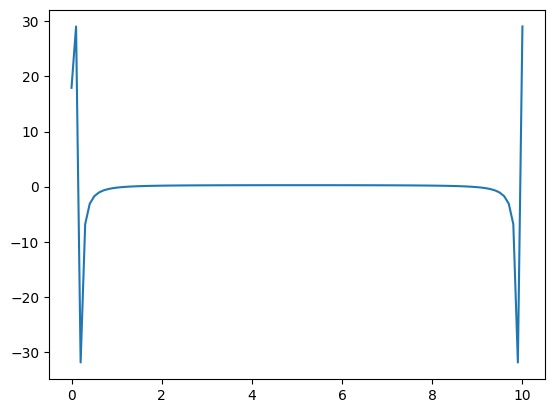

In [112]:
x = np.linspace(0.0, 10.0, 100)
y = np.sin(x)
yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

fig, ax = plt.subplots()
ax.plot(x, yf)
plt.show()

# Useful links
- https://trends.google.com/trends/explore?date=all&geo=IN&q=wheat%20prices
- https://stackoverflow.com/questions/48470691/access-google-spreadsheet-on-google-colaboratory-jupyter-notebook
- https://www.cia.gov/library/publications/the-world-factbook/geos/in.html
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_numeric.html
- https://stackoverflow.com/questions/15891038/change-data-type-of-columns-in-pandas
- https://gspread.readthedocs.io/en/latest/user-guide.html#getting-all-values-from-a-row-or-a-column
- https://www.geeksforgeeks.org/convert-the-column-type-from-string-to-datetime-format-in-pandas-dataframe/
- https://colab.research.google.com/notebooks/bigquery.ipynb#scrollTo=dWf7KIxjKtA0
- https://cloud.google.com/bigquery/docs/quickstarts/quickstart-web-ui
- http://www.fao.org/prices/en/
- https://stackoverflow.com/questions/29819671/get-number-of-rows-before-and-after-a-certain-index-value-in-pandas
- https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html
- https://stackoverflow.com/questions/45554008/error-in-python-script-expected-2d-array-got-1d-array-instead
- https://cloud.google.com/bigquery/public-data/
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html
- https://matplotlib.org/3.1.0/gallery/text_labels_and_annotations/legend.html#sphx-glr-gallery-text-labels-and-annotations-legend-py
- Dataset: https://console.cloud.google.com/marketplace/product/the-world-bank/global-health


